In [1]:
! pip install NEURON
! pip install bmtk
# as new version of neuron and bmtk come out we may need to install a specific version
import os
from os.path import normpath, sep, join

root = 'Borgers-Examples-in-BMTK' # name of github repo
folder = '23-WBneuron' # name of folder in Github just change this line 
pathlist = normpath(os.getcwd()).split(sep)
if pathlist[-1] != folder:
  rootidx = pathlist.index(root) if root in pathlist else -1
  if rootidx>0:
    os.chdir(join(sep,*pathlist[:rootidx]))
  !git clone https://github.com/GregGlickert/Borgers-Examples-in-BMTK
  os.chdir(join(root,folder))
print(os.getcwd())
%ls

     |████████████████████████████████| 12.6 MB 7.5 MB/s 
     |████████████████████████████████| 471 kB 8.6 MB/s 
Cloning into 'Borgers-Examples-in-BMTK'...
remote: Enumerating objects: 849, done.
remote: Counting objects: 100% (849/849), done.
remote: Compressing objects: 100% (466/466), done.
remote: Total 849 (delta 449), reused 724 (delta 357), pack-reused 0
Receiving objects: 100% (849/849), 30.76 MiB | 22.82 MiB/s, done.
Resolving deltas: 100% (449/449), done.
/content/Borgers-Examples-in-BMTK/23-WBneuron
23-WBEntrainment.ipynb  components/


# Modeling Entrainment of a WB Neuron (with BMTK)

In this notebook, we model 1:1 entrainment of a standard WB neuron under a constant frequency of excitatory input pulses. The entrainment is 1:1 because the WB neuron will fire at the same frequency as the input.


## Cell Definition
A standard WB cell is used in this example. 

**WB Cell**
* $\alpha_{n} = -0.01*(v+34)/(e^{-0.1*(v+34)}-1)$
* $\beta_{n} = 0.125*e^{-(v+44)/80}$
* $\alpha_{m} = 0.1*(v+35)/(1-e^{-(v+35)/10})$
* $\beta_{m} = 4*e^{-(v+60)/18}$
* $\alpha_{h} = 0.07*e^{-(v+58)/20}$
* $\beta_{h} = 1/(e^{-0.1*(v+28)}+1)$

Compile .mod Files

In [2]:
import os
print(os.system('nrnivmodl components/mechanisms')) # compile modfiles. Return 0 for success, 1 for failure.

0


### 1.Building the Network
There is only 1 cell in this network, thus only a WB cell will be added. No network connections are necessary

In [3]:
import numpy as np
import logging

from bmtk.builder.networks import NetworkBuilder

net = NetworkBuilder('network')
net.add_nodes(N=1,pop_name='WB',     
        model_type='biophysical',
        model_template='hoc:WBInhCell',  # WBInhCell hoc definition
        morphology='blank.swc')

#### Building
After defining our network, we build and save it in a network folder.

In [4]:
net.build()
net.save_nodes(output_dir='network')

#### External Input
We then create a 'virtual' cell that supplies the excitatory synaptic input to our WB cell.

In [5]:
extnet = NetworkBuilder('extnet')
extnet.add_nodes(N=1,pop_name='Inp',
            potential='exc',
            model_type='virtual')

Add an excitatory connection from our virtual cell to the WB cell using tau1=0.5 ms and t2=2 ms. These parameters are specified in ExcToInh.json

In [6]:
extnet.add_edges(source={'pop_name':'Inp'}, target=net.nodes(),
                   connection_rule=1,
                   syn_weight=0.03,               #synaptic weight specified in Borger's book ch 23
                   delay=5,
                   weight_function=None,
                   target_sections=['soma'],
                   distance_range=[0.0, 150.0],
                   dynamics_params='ExcToInh.json',
                   model_template='exp2syn')

In [7]:
extnet.build()
extnet.save_nodes(output_dir='network')
extnet.save_edges(output_dir='network')

#### Adding Spike Train

In [8]:
from bmtk.utils.reports.spike_trains import SpikeTrains

spikes = SpikeTrains(population='extnet')
spikes.add_spikes(node_ids=0, 
                    timestamps=[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800])
spikes.to_sonata('input/ConstantSpike.h5')

This next cell is used to build the simulation. This step is already completed for you.

In [9]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='.',
                network_dir='network',
                 tstop=800.0, dt=0.1,
                 report_vars=['v'],     # Record membrane potential and calcium (default soma)
                 spikes_inputs=[('extnet',   # Name of population which spikes will be generated for
                                'input/ConstantSpike.h5')],
                 include_examples=False,    # Copies components files
                 compile_mechanisms=False,   # Will try to compile NEURON mechanisms
                 config_file = 'config.json'
                )

### Run the Simulation

In [10]:
from bmtk.simulator import bionet


conf = bionet.Config.from_json('config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2022-03-23 18:10:42,530 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


2022-03-23 18:10:42,612 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2022-03-23 18:10:42,626 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2022-03-23 18:10:42,641 [INFO] Building virtual cell stimulations for extnet_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for extnet_spikes


2022-03-23 18:10:42,683 [INFO] Running simulation for 800.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 800.000 ms with the time step 0.100 ms


2022-03-23 18:10:42,691 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2022-03-23 18:10:42,698 [INFO] Block save every 5000 steps


INFO:NEURONIOUtils:Block save every 5000 steps


2022-03-23 18:10:42,961 [INFO]     step:5000 t_sim:500.00 ms


INFO:NEURONIOUtils:    step:5000 t_sim:500.00 ms


2022-03-23 18:10:43,074 [INFO]     step:8000 t_sim:800.00 ms


INFO:NEURONIOUtils:    step:8000 t_sim:800.00 ms


2022-03-23 18:10:43,097 [INFO] Simulation completed in 0.4137 seconds 


INFO:NEURONIOUtils:Simulation completed in 0.4137 seconds 


If the simulation ran correctly, we can now print out results:

In [11]:
from bmtk.analyzer.spike_trains import to_dataframe

results_df = to_dataframe(config_file='config.json')
print('Number of Spikes: {}'.format(len(results_df)))
results_df.head()

Number of Spikes: 5


,timestamps,node_ids,population
0,174.5,0,network
1,322.1,0,network
2,471.4,0,network
3,621.2,0,network
4,771.2,0,network


As you can see, the WB neuron fired ~7.8 ms after the spike in our virtual cell. We defined 5 ms delay in our synapse, so if this delay is set to 0 and the simulation is re-run, the WB neuron would fire ~2.8 ms after the virtual cell spike.

We can now plot our results using an in built bmtk function plot_traces

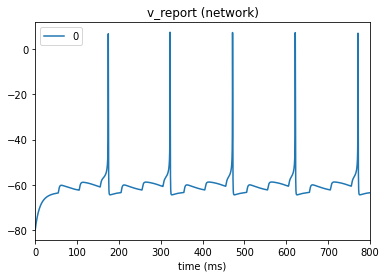

In [12]:
from bmtk.analyzer.compartment import plot_traces
_ = plot_traces(config_file='config.json', node_ids=[0], report_name='v_report')


## Additional Plot Features
It is easier to work with this data if we obtain it in array form, and we can use well documented matplotlib features while plotting.

In [13]:
from bmtk.utils.reports.compartment import CompartmentReport

pop_name = 'WB'
report = CompartmentReport('output/v_report.h5',
population=pop_name, mode='r')
v_trace = (report.data(node_id=0))
time = np.arange(report.tstart(), report.tstop(), report.dt())

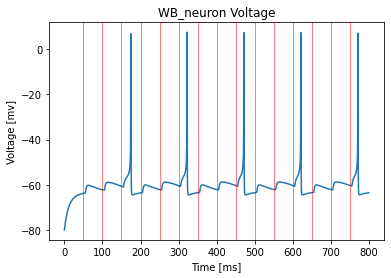

In [14]:
import matplotlib.pyplot as plt
plt.plot(time, v_trace)
plt.ylabel('Voltage [mv]')
plt.xlabel('Time [ms]')
plt.title('WB_neuron Voltage')
# add red verticle lines that mark when the virtual cell spikes
for i in range(15):
    plt.axvline(x=50*i+50, linewidth=0.5, color='r')
plt.show()

After overlaying the virtual cell spike times (vertical red lines) we have created a plot that looks very similar to the example in chapter 23 of Borgers' book, "An Introduction to Modeling Neuronal Dynamics."